# Preparing the corpus

In [3]:
# hide jupyter warning
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [5]:
#import pyLDAvis
#import pyLDAvis.gensim_models

from tqdm import tqdm_notebook as tqdm

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

In [6]:
df = pd.read_json('../input/iphone-12-tweets-fr.json', lines=True)

In [7]:
# remove duplicates 
# 840 tweets had been droped

df = df[df['lang'] == 'fr']
df = df.sort_values("content") 
  
# dropping ALL duplicte values 
df = df.drop_duplicates(subset ="content", keep = 'first')

In [8]:
df.content[0]

'La batterie de l’iphone 12 est de qualité \U0001f90c🏾'

In [9]:
df['date'] = pd.to_datetime(df['date']).dt.dates

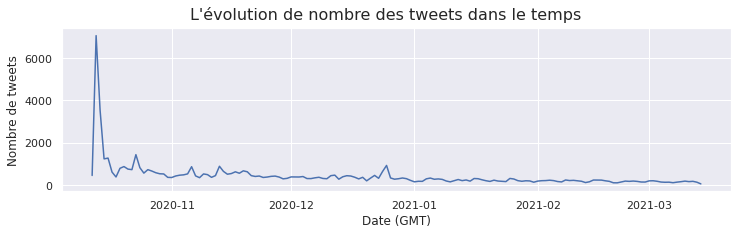

In [10]:
fig = plt.figure(figsize=(12, 3))
plt.plot(df.groupby(['date']).agg(['count'])['id'])
# Finally graph these metrics across the topic numbers:
                
fig.suptitle('L\'évolution de nombre des tweets dans le temps', fontsize=16)
plt.xlabel('Date (GMT)', fontsize=12)
plt.ylabel('Nombre de tweets', fontsize=12)
plt.show()

In [11]:
# selectionner que les tweets qui répondent au requetes de l'utilisateur

data = df['content']

with open('../input/keywords.txt', encoding='utf-8') as f:
    keywords = f.read().splitlines()

data = data[data.str.contains('|'.join(keywords), case=False)]
#data = data[data.str.contains('batterie', case=False)]

# supprimer les tweets inutiles (publicité, concours ..)

with open('../input/ads_words.txt', encoding='utf-8') as f:
    ads_words = f.read().splitlines()

data = data[~data.str.contains('|'.join(ads_words), case=False)]

In [13]:
import re
import json
from html.parser import HTMLParser
from io import StringIO

import demoji
demoji.download_codes()

... OK (Got response in 0.38 seconds)
Writing emoji data to /home/azureuser/.demoji/codes.json ...
... OK


In [14]:
class MLStripper(HTMLParser):
        def __init__(self):
            super().__init__()
            self.reset()
            self.strict = False
            self.convert_charrefs= True
            self.text = StringIO()
        def handle_data(self, d):
            self.text.write(d)
        def get_data(self):
            return self.text.getvalue()
        
def html_free_text(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def emoji_free_text(text):
    return demoji.replace(text, '').strip()

def url_free_text(text):
    text = re.sub(r'(?:\@|https?\://)\S+', '', text)
    return text
    
with open('../input/abrivot_fr.json', encoding='utf-8') as f:
        abrivot = json.load(f)   
        
def abrivot_free_text(text):
    words = text.lower().split()
    text_out = [abrivot[word] if word in abrivot else word for word in words]
    return ' '.join(text_out)

def punct_free_text(text):
    text_out = simple_preprocess(text, deacc=True, min_len=3)
    #return ' '.join(text_out)
    return text_out

## Pre-Process the data

In [57]:
# save the data
import pickle

with open("../saved models/data.txt", "wb") as fp:
    pickle.dump(data, fp)

In [15]:
%%time

data_free_html = data.apply(html_free_text)
data_free_emoji = data_free_html.apply(emoji_free_text)
data_free_url = data_free_emoji.apply(url_free_text)
data_free_abrivot = data_free_url.apply(abrivot_free_text)
data_free_punct = data_free_url.apply(punct_free_text)

CPU times: user 13.7 s, sys: 2.99 ms, total: 13.7 s
Wall time: 13.7 s


In [51]:
# save the preprocessed data

data_free_punct.to_pickle('../saved models/data_free_punct.pkl')

In [16]:
# Build the bigram and trigrams

data = list(data_free_punct)

bigram = gensim.models.Phrases(data, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [17]:
# define a preprocessing function

# only need tagger, no need for parser and named entity recognizer, for faster implementation
nlp = spacy.load('fr_core_news_lg', disable=['parser', 'ner'])

# get stopwords
# ask the user to specify the brand name to be added to the stopwords
# or implement it manually
with open('../input/fr_stopwords.txt', encoding='utf-8') as f:
    fr_stopwords = f.read().splitlines()
stop_words = nlp.Defaults.stop_words.union(fr_stopwords)


# final preprocesser
def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN']):
    
    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    
    # remove stopwords, short tokens and letter accents 
    #texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    texts = [[word for word in doc if word not in stop_words] for doc in texts]

    
    # bi-gram and tri-gram implementation
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

In [18]:
%%time

data_ready = process_words(data)

CPU times: user 1min, sys: 17.1 ms, total: 1min
Wall time: 1min


In [19]:
# create the Dictionary

id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 4603


In [20]:
# create the corpus
corpus = [id2word.doc2bow(text) for text in data_ready]

In [21]:
dict_corpus = {}

for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if id2word[idx] in dict_corpus:
            dict_corpus[id2word[idx]] += freq
        else:
            dict_corpus[id2word[idx]] = freq

dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

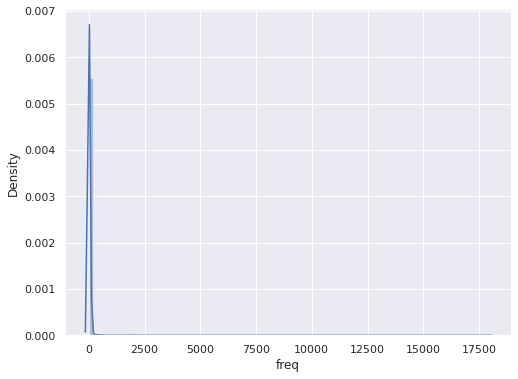

In [22]:
plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100);

In [23]:
dict_df.sort_values('freq', ascending=False).head(10)

,freq
iphone,17891
max,3282
photo,2085
pro,2051
prix,1891
chargeur,1671
ecran,1443
batterie,1086
couleur,689
coque,649


In [24]:
# remove the 3 top words
threshold = dict_df.sort_values('freq', ascending=False).iloc[9].values[0]
extension = dict_df[dict_df.freq>threshold].index.tolist()

extension = [word for word in extension if word not in keywords]

In [25]:
# ask the user to specify the brand name to be added to the stopwords
# or implement it manually
# tweek the extension list to get words with typo
extension.append('appl')
extension.append('iphon')

In [26]:
# add high frequency words to stop words list
stop_words.update(extension)
# rerun the process_words function
data_ready = process_words(data)
# recreate Dictionary
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 4484


In [27]:
# Filter extreme words
# Filter out words that occur less than 20 documents, or more than
# 90% of the documents.

id2word.filter_extremes(no_below=20, no_above=0.9)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 409


In [28]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [34]:
#save the doctionnary
import pickle

with open('../saved models/id2word.pkl', 'wb') as fp:
        pickle.dump(id2word, fp, pickle.HIGHEST_PROTOCOL)

In [32]:
#save the corpus

with open("../saved models/corpus.txt", "wb") as fp:
    pickle.dump(corpus, fp)

# Finding the optimal number of topics

In [39]:
from gensim.models import LdaMulticore, CoherenceModel

In [38]:
%%time

num_topics = list(range(20, 30, 1)[1:])
num_keywords = 10

LDA_models = {}
LDA_topics = {}
for i in tqdm(num_topics):
    LDA_models[i] = LdaMulticore(corpus=corpus,
                                id2word=id2word,
                                num_topics=i,
                                chunksize=2000,
                                passes=25,
                                iterations=70,
                                decay=0.5,
                                random_state=100
                                )

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 4min 19s, sys: 4.86 s, total: 4min 24s
Wall time: 4min 23s


In [40]:
# Now create a function to derive the Jaccard similarity of two topics:

def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [41]:
# Use the above to derive the mean stability across topics by considering the next topic:

LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [42]:
# calculate the coherence value with the built in gensim

coherences = [CoherenceModel(model=LDA_models[i], texts=data_ready,
                             dictionary=id2word, coherence='c_v', topn=num_keywords).get_coherence() for i in num_topics[:-1]]

In [43]:
# From here derive the ideal number of topics roughly through the difference between the coherence and stability per number of topics:


coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(len(num_topics) - 1)[:-1]]
#coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

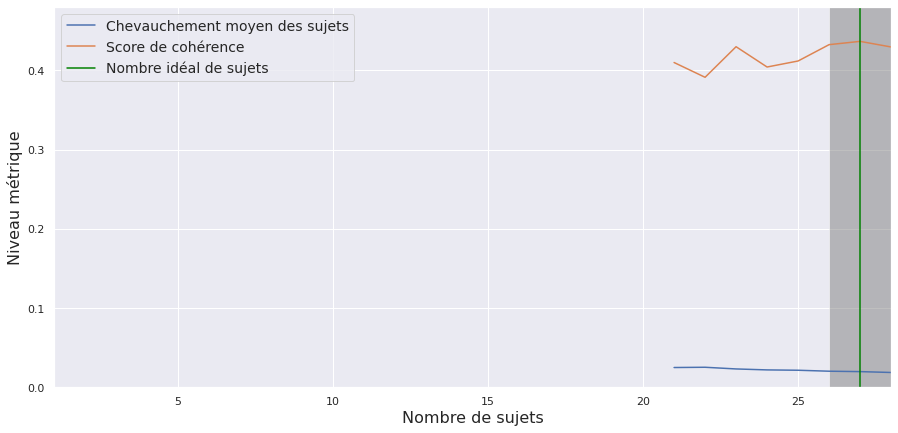

In [44]:
# Finally graph these metrics across the topic numbers:

plt.figure(figsize=(15,7))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Chevauchement moyen des sujets')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Score de cohérence')

ax.axvline(x=ideal_topic_num, label='Nombre idéal de sujets', color='green')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.set_ylabel('Niveau métrique', fontsize=16)
ax.set_xlabel('Nombre de sujets', fontsize=16)
plt.legend(fontsize=14)
plt.show()   

Your ideal number of topics will maximize coherence and minimize the topic overlap based on Jaccard similarity.

In [45]:
print('Ideal number of topics: ', ideal_topic_num)

Ideal number of topics:  27


# Building the LDA Model

Download the LDA mallet from `!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip`  
Extract the model `!unzip mallet-2.0.8.zip`

In [46]:
ldamodel = LDA_models[ideal_topic_num]

In [47]:
# Compute Coherence Score
coherence_model_ldamodel = CoherenceModel(model=ldamodel, texts=data_ready, dictionary=id2word, coherence='c_v', topn=num_keywords)
coherence_ldamodel = coherence_model_ldamodel.get_coherence()
print('Coherence Score: ', coherence_ldamodel)

Coherence Score:  0.436754974067109


In [48]:
from pprint import pprint
# display topics
pprint(ldamodel.show_topics(num_topics = ideal_topic_num, formatted=True))

[(0,
  '0.390*"qualite" + 0.252*"photo" + 0.095*"suite" + 0.085*"rapport" + '
  '0.047*"gnt" + 0.039*"pote" + 0.029*"enfant" + 0.024*"fabrication" + '
  '0.017*"achat" + 0.007*"part"'),
 (1,
  '0.162*"difference" + 0.150*"keynote" + 0.130*"gamme" + 0.081*"place" + '
  '0.063*"cause" + 0.057*"jeu" + 0.056*"fcfa" + 0.038*"meuf" + '
  '0.037*"generation" + 0.036*"vitesse"'),
 (2,
  '0.210*"modele" + 0.147*"niveau" + 0.133*"recharge" + 0.125*"capteur" + '
  '0.070*"base" + 0.058*"zoom" + 0.055*"bloc" + 0.038*"accord" + '
  '0.032*"abonnement" + 0.030*"adaptateur"'),
 (3,
  '0.124*"vie" + 0.111*"pixel" + 0.097*"face" + 0.086*"mode" + 0.077*"bug" + '
  '0.076*"raison" + 0.072*"concours" + 0.052*"min" + 0.042*"tete" + '
  '0.042*"option"'),
 (4,
  '0.297*"euro" + 0.137*"test_bluetooth" + 0.082*"temps" + 0.069*"argent" + '
  '0.067*"coute" + 0.054*"design" + 0.048*"stock" + 0.028*"remise" + '
  '0.028*"magasin" + 0.027*"colis"'),
 (5,
  '0.327*"taille" + 0.124*"forfait" + 0.067*"pouce" + 0.064

In [49]:
# save the model for later

import pickle
pickle.dump(ldamodel, open("../saved models/ldamodel.pkl", "wb"))

# load the model
#ldamallet = pickle.load(open("../saved models/ldamallet.pkl", "rb"))

In [57]:
# distribution of topics for each document

tm_results = ldamodel[corpus]

# We can get the most dominant topic of each document as below:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
# get most probable words for the given topicis

topics = [[(term, round(wt, 3)) for term, wt in ldamodel.show_topic(n, topn=20)] for n in range(0, ldamodel.num_topics)]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
# create a dataframe for term-topic matrix:

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics],
                         columns = ['Terme '+str(i) for i in range(1, 21)],
                         index=['Sujet '+str(t) for t in range(1, ldamodel.num_topics+1)]).T
topics_df.head()

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Sujet 1,Sujet 2,Sujet 3,Sujet 4,Sujet 5,Sujet 6,Sujet 7,Sujet 8,Sujet 9,Sujet 10,...,Sujet 18,Sujet 19,Sujet 20,Sujet 21,Sujet 22,Sujet 23,Sujet 24,Sujet 25,Sujet 26,Sujet 27
Terme 1,keynote,magsafe,protection,telephone,question,batterie,heure,sortie,couleur,appareil,...,chargeur,soir,difference,igeneration,ecouteur,taille,compte,oled,prix,pouce
Terme 2,devoile,mise,coque,cote,version,charge,niveau,choix,site,annonce,...,boite,rapport,video,octobre,chargeur,smartphone,deballage,samsung,recu,capteur
Terme 3,utilisation,recharge,homepod,mode,promo,demontage,janvier,gosse,cadeau,part,...,livre,gamme,pub,marche,place,test_bluetooth,plan,lieu,lien,stockage
Terme 4,choisir,voiture,client,bientot,peine,arrivee,vendredi,sort,change,point,...,prefere,argent,presse_citron,cause,internet,test,voi,envie,pacemaker,cuir
Terme 5,probleme,serie,succe,publication,reponse,termine,encoche,regarde,generation,fonction,...,fil,matin,partage,bleu,rumeur,fonds,performance,operateur,novembre,etui


In [62]:
# another option

# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics],
                         columns = ['Terme par Sujet'],
                         index=['Sujet '+str(t) for t in range(1, ldamodel.num_topics+1)] )
topics_df

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Terme par Sujet
Sujet 1,"keynote, devoile, utilisation, choisir, probleme, super, dommage, partie, air, dispo, lot, resolution, belgium, definition, charge, con, surprise, reduction, mise, besoin"
Sujet 2,"magsafe, mise, recharge, voiture, serie, carte, penurie, presentation, support, connexion, airpod, propose, poste, xiaomi, induction, youtube, chargeur, ecran, air, besoin"
Sujet 3,"protection, coque, homepod, client, succe, objectif, vena, plaisir, coque_etui, cherche, affaire, tech, note, pose, gamme, technologie, offre, compte, peur, fin"
Sujet 4,"telephone, cote, mode, bientot, publication, droit, poids, tweet, famille, commande, prevu, bouton, support, huawei, avance, capte, samsung, boite, besoin, vend"
Sujet 5,"question, version, promo, peine, reponse, bloc, commence, article, peur, code, espere, orange, jaune, processeur, eau, capture, facon, achat, graphite, gamme"
Sujet 6,"batterie, charge, demontage, arrivee, termine, dinguerie, possession, date, utilisation, performance, avis, offre, igeneration, chargeur, balle, promo, induction, magsafe, attention, processeur"
Sujet 7,"heure, niveau, janvier, vendredi, encoche, stabilisation, equipe, condition, predecesseur, defaut, studio, batterie, chaud, marque, cas, interet, besoin, site, taille, ecran"
Sujet 8,"sortie, choix, gosse, sort, regarde, sony, recherche, dossier, prix, baisse, support, prise, octobre, charge, voiture, photo, casse, igeneration, bleu, vend"
Sujet 9,"couleur, site, cadeau, change, generation, compatible, comprend, carte_sim, travail, pigeon, moche, ouverture, paiement, ville, recu, lance, homme, taille, mail, besoin"
Sujet 10,"appareil, annonce, part, point, fonction, baisse, ami, mec, presente_modele, actualite, huawei, evolution, capte, livre, application, gamme, objectif, vente, carte_sim, heure"


/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


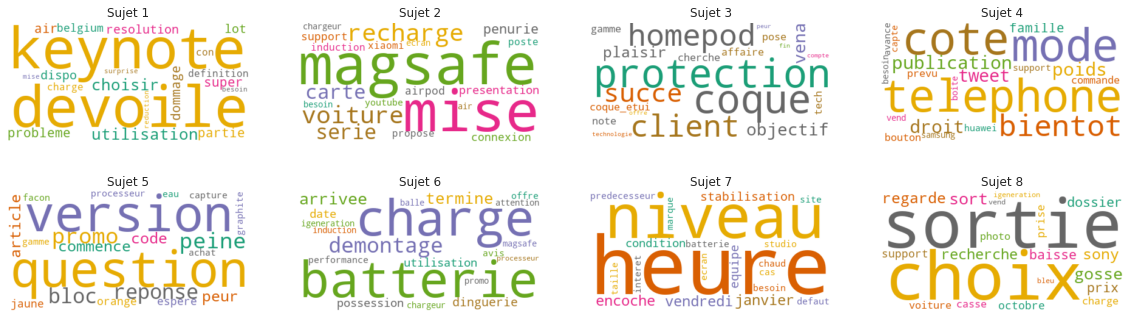

In [63]:
# worldcloud

# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(8):

    wc.generate(text=topics_df["Terme par Sujet"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [64]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, id2word)
vis

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17     0.406750  0.016130  1       1        6.483930
25    -0.036968  0.202458  2       1        5.388024
15    -0.037872  0.142331  3       1        5.207220
5     -0.033250  0.024601  4       1        4.774821
22    -0.036511 -0.010255  5       1        4.361527
2     -0.043620  0.223472  6       1        4.219225
1     -0.018620 -0.045538  7       1        4.084540
14    -0.035305 -0.026299  8       1        3.924077
12    -0.016049 -0.035440  9       1        3.879221
18    -0.045407  0.228686  10      1        3.814438
10    -0.006842 -0.018319  11      1        3.764649
8     -0.035001 -0.020666  12      1        3.698208
9     -0.006899 -0.045655  13      1        3.643069
16    -0.037769 -0.033623  14      1        3.528605
4     -0.036541 -0.046125  15      1        3.481973
11    -0.042684  0.110937  16      1        3.478485
24    -0.040345 -0.039966  17      1        3.470734
0     -0.038469 -0.052698  18      1        3.364574
3     -0.039000 -0.077758  19      1        3.307283
26    -0.022114 -0.034929  20      1        3.228610
21     0.394266  0.007266  21      1        3.166515
23    -0.019662 -0.149172  22      1        3.094186
13    -0.022719 -0.010180  23      1        2.891756
20    -0.038020 -0.057913  24      1        2.728108
6     -0.038769 -0.146190  25      1        2.568887
19    -0.036152 -0.049263  26      1        2.372218
7     -0.036430 -0.055892  27      1        2.075119, topic_info=         Term        Freq        Total Category  logprob  loglift
9    prix      1184.00000  1184.000000  Default  30.0000  30.0000
4    chargeur  1338.00000  1338.000000  Default  29.0000  29.0000
23   photo     1023.00000  1023.000000  Default  28.0000  28.0000
24   batterie  856.00000   856.000000   Default  27.0000  27.0000
16   euro      440.00000   440.000000   Default  26.0000  26.0000
..    ...            ...          ...       ...      ...      ...
117  prefere   0.05728     55.188590    Topic27 -9.1761  -2.9954 
122  heure     0.05728     181.836650   Topic27 -9.1761  -4.1878 
259  hesite    0.05728     32.130538    Topic27 -9.1761  -2.4545 
4    chargeur  0.05728     1338.082641  Topic27 -9.1761  -6.1837 
27   keynote   0.05728     154.568640   Topic27 -9.1761  -4.0253 

[1268 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
324   1      0.854612  absence
324   23     0.134939  absence
273   20     0.986310  accord 
1     15     0.939354  achat  
203   16     0.990874  achete 
...   ..          ...    ...  
195   7      0.982832  voiture
189   20     0.989770  vue    
323   1      0.323479  xiaomi 
323   7      0.646957  xiaomi 
98    9      0.989215  youtube

[376 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 26, 16, 6, 23, 3, 2, 15, 13, 19, 11, 9, 10, 17, 5, 12, 25, 1, 4, 27, 22, 24, 14, 21, 7, 20, 8])

# Dominant Topics for Each Document


In [146]:
# create a dataframe
corpus_topic_df = pd.DataFrame()

# get the Titles from the original dataframe
corpus_topic_df['Tweet_id'] = data_free_abrivot.index
corpus_topic_df['Sujet dominant'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Mot clés'] = [topics_df.iloc[t[0]]['Terme par Sujet'] for t in corpus_topics]
corpus_topic_df.head(10)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Tweet_id,Sujet dominant,Contribution %,Mot clés
0,19381,10,51.85,"appareil, annonce, part, point, fonction, baisse, ami, mec, presente_modele, actualite, huawei, evolution, capte, livre, application, gamme, objectif, vente, carte_sim, heure"
1,6029,4,25.93,"telephone, cote, mode, bientot, publication, droit, poids, tweet, famille, commande, prevu, bouton, support, huawei, avance, capte, samsung, boite, besoin, vend"
2,61267,18,51.85,"chargeur, boite, livre, prefere, fil, spigen, absence, femme, histoire, min, enfant, limite, induction, xiaomi, air, coque_etui, samsung, test, charge, protection"
3,61645,18,51.85,"chargeur, boite, livre, prefere, fil, spigen, absence, femme, histoire, min, enfant, limite, induction, xiaomi, air, coque_etui, samsung, test, charge, protection"
4,53240,4,51.85,"telephone, cote, mode, bientot, publication, droit, poids, tweet, famille, commande, prevu, bouton, support, huawei, avance, capte, samsung, boite, besoin, vend"
5,11631,26,20.74,"prix, recu, lien, pacemaker, novembre, vena, super, chaud, avis, compte, achat, utilisation, partage, rapport, coque, offre, facon, euro, difference, protection"
6,2833,1,3.70,"keynote, devoile, utilisation, choisir, probleme, super, dommage, partie, air, dispo, lot, resolution, belgium, definition, charge, con, surprise, reduction, mise, besoin"
7,53242,18,34.57,"chargeur, boite, livre, prefere, fil, spigen, absence, femme, histoire, min, enfant, limite, induction, xiaomi, air, coque_etui, samsung, test, charge, protection"
8,32661,1,3.70,"keynote, devoile, utilisation, choisir, probleme, super, dommage, partie, air, dispo, lot, resolution, belgium, definition, charge, con, surprise, reduction, mise, besoin"
9,48756,4,51.85,"telephone, cote, mode, bientot, publication, droit, poids, tweet, famille, commande, prevu, bouton, support, huawei, avance, capte, samsung, boite, besoin, vend"


We can use pandas groupby function on “Dominant Topic” column and get the document counts for each topic and its percentage in the corpus with chaining agg function.

In [70]:
# Documents distribution ovec topics

dominant_topic_df = corpus_topic_df.groupby('Sujet dominant').agg(
                                  Nombre_de_Tweet = ('Sujet dominant', np.size),
                                  Importance_de_Sujet = ('Sujet dominant', np.size)).reset_index()

dominant_topic_df['Importance_de_Sujet'] = dominant_topic_df['Importance_de_Sujet'].apply(lambda row: round((row*100) / len(corpus), 2))

dominant_topic_df

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Sujet dominant,Nombre_de_Tweet,Importance_de_Sujet
0,1,4907,25.49
1,2,541,2.81
2,3,603,3.13
3,4,454,2.36
4,5,426,2.21
5,6,1054,5.48
6,7,224,1.16
7,8,187,0.97
8,9,583,3.03
9,10,528,2.74


In [71]:
# the most dominant document per topic

corpus_topic_df.groupby('Sujet dominant').\
    apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False).iloc[0])).reset_index(drop=True)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Tweet_id,Sujet dominant,Contribution %,Mot clés
0,29193,1,80.74,"keynote, devoile, utilisation, choisir, probleme, super, dommage, partie, air, dispo, lot, resolution, belgium, definition, charge, con, surprise, reduction, mise, besoin"
1,39121,2,75.93,"magsafe, mise, recharge, voiture, serie, carte, penurie, presentation, support, connexion, airpod, propose, poste, xiaomi, induction, youtube, chargeur, ecran, air, besoin"
2,44280,3,75.93,"protection, coque, homepod, client, succe, objectif, vena, plaisir, coque_etui, cherche, affaire, tech, note, pose, gamme, technologie, offre, compte, peur, fin"
3,2288,4,67.90,"telephone, cote, mode, bientot, publication, droit, poids, tweet, famille, commande, prevu, bouton, support, huawei, avance, capte, samsung, boite, besoin, vend"
4,53724,5,80.74,"question, version, promo, peine, reponse, bloc, commence, article, peur, code, espere, orange, jaune, processeur, eau, capture, facon, achat, graphite, gamme"
5,47277,6,75.93,"batterie, charge, demontage, arrivee, termine, dinguerie, possession, date, utilisation, performance, avis, offre, igeneration, chargeur, balle, promo, induction, magsafe, attention, processeur"
6,10806,7,67.90,"heure, niveau, janvier, vendredi, encoche, stabilisation, equipe, condition, predecesseur, defaut, studio, batterie, chaud, marque, cas, interet, besoin, site, taille, ecran"
7,51215,8,75.93,"sortie, choix, gosse, sort, regarde, sony, recherche, dossier, prix, baisse, support, prise, octobre, charge, voiture, photo, casse, igeneration, bleu, vend"
8,12727,9,75.93,"couleur, site, cadeau, change, generation, compatible, comprend, carte_sim, travail, pigeon, moche, ouverture, paiement, ville, recu, lance, homme, taille, mail, besoin"
9,1605,10,75.93,"appareil, annonce, part, point, fonction, baisse, ami, mec, presente_modele, actualite, huawei, evolution, capte, livre, application, gamme, objectif, vente, carte_sim, heure"


# Hyper parameter tuning

### minimum_probability

In [72]:
from gensim.models import LdaMulticore, CoherenceModel

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
# supporting function
def compute_coherence_values_2(corpus, dictionary, k, mp):
    
    lda_model = LdaMulticore(corpus=corpus,
                            id2word=id2word,
                            num_topics=k,
                            random_state=100,
                            chunksize=2000,
                            passes=25,
                            iterations=70,
                            decay=0.5,                            
                            #alpha=a,
                            #eta=b,
                            minimum_probability = mp 
                            )
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
minimum_probabilities = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
results = {}

for mp in tqdm(minimum_probabilities):
    # get the coherence score for the given parameters
    cv = compute_coherence_values_2(corpus=corpus, dictionary=id2word, 
                                      k=16, mp=mp)
    results[mp] = cv

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-74-80d3a1e5527a>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for mp in tqdm(minimum_probabilities):


  0%|          | 0/8 [00:00<?, ?it/s]

In [133]:
minimum_probability = list(results.keys())           # list() needed for python 3.x

coherence_score = list(results.values())        # ditto

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


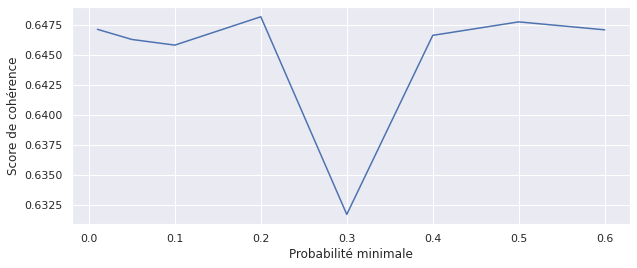

In [138]:
fig = plt.figure(figsize=(10, 4))
# Finally graph these metrics across the topic numbers:

plt.plot(minimum_probability, coherence_score, '-')
plt.xlabel("Probabilité minimale")
plt.ylabel("Score de cohérence")
plt.show()

In [77]:
lda_model = LdaMulticore(corpus=corpus,
                            id2word=id2word,
                            num_topics=14,
                            random_state=100,
                            chunksize=2000,
                            passes=25,
                            iterations=70,
                            minimum_probability=0.6
                            )

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.131890  0.262179  1       1        10.208809
11     0.125567 -0.093258  2       1        8.108902 
1      0.272970  0.041179  3       1        8.008799 
7     -0.170495 -0.200165  4       1        7.811239 
2      0.262340 -0.042508  5       1        7.616536 
4     -0.007711 -0.214205  6       1        7.153683 
5     -0.072145  0.211454  7       1        6.996663 
12    -0.038100  0.082120  8       1        6.766271 
10     0.116626  0.035211  9       1        6.592062 
8     -0.111712 -0.074999  10      1        6.591410 
6      0.052283  0.066652  11      1        6.334206 
9     -0.135240 -0.126195  12      1        6.310319 
0     -0.077325  0.031036  13      1        5.878656 
13    -0.085168  0.021499  14      1        5.622444 , topic_info=          Term         Freq        Total Category  logprob  loglift
9    prix       1331.000000  1331.000000  Default  30.0000  30.0000
4    chargeur   1406.000000  1406.000000  Default  29.0000  29.0000
23   photo      1115.000000  1115.000000  Default  28.0000  28.0000
24   batterie   997.000000   997.000000   Default  27.0000  27.0000
16   euro       461.000000   461.000000   Default  26.0000  26.0000
..    ...              ...          ...       ...      ...      ...
298  ecologie   20.567426    31.854450    Topic14 -4.2893   2.4409 
20   choix      9.284335     42.996135    Topic14 -5.0847   1.3456 
324  absence    3.455527     46.765946    Topic14 -6.0730   0.2732 
231  evolution  0.085342     13.965438    Topic14 -9.7741  -2.2193 
144  carte      0.086204     52.837399    Topic14 -9.7640  -3.5399 

[497 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
324   1      0.898089  absence
324   14     0.064149  absence
273   2      0.977767  accord 
1     12     0.971682  achat  
203   2      0.990177  achete 
...   ..          ...    ...  
189   9      0.970901  vue    
323   1      0.432493  xiaomi 
323   8      0.528602  xiaomi 
98    2      0.828566  youtube
98    6      0.168522  youtube

[412 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 12, 2, 8, 3, 5, 6, 13, 11, 9, 7, 10, 1, 14])

### Dirichlet hyperparameter alpha: Document-Topic Density
### Dirichlet hyperparameter beta: Word-Topic Density

In [126]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=corpus,
                            id2word=id2word,
                            num_topics=ideal_topic_num,
                            random_state=100,
                            chunksize=2000,
                            passes=25,
                            iterations=70,
                            decay=0.5,                            
                            alpha=a,
                            eta=b
                            )
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v', topn=num_keywords)
    
    return coherence_model_lda.get_coherence()

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [127]:
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [128]:
for a in tqdm(alpha):
    # iterare through beta values
    for b in tqdm(beta):
        # get the coherence score for the given parameters
        cv = compute_coherence_values(corpus=corpus, dictionary=id2word, 
                                      k=ideal_topic_num, a=a, b=b)
        # Save the model results
        model_results['Topics'].append(ideal_topic_num)
        model_results['Alpha'].append(a)
        model_results['Beta'].append(b)
        model_results['Coherence'].append(cv)

model_results_df = pd.DataFrame(model_results)
model_results_df.to_csv('../output/lda_tuning_results.csv', index=False)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-128-02ed4645deb9>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for a in tqdm(alpha):


  0%|          | 0/6 [00:00<?, ?it/s]

<ipython-input-128-02ed4645deb9>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for b in tqdm(beta):


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-128-02ed4645deb9>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for b in tqdm(beta):


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-128-02ed4645deb9>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for b in tqdm(beta):


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-128-02ed4645deb9>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for b in tqdm(beta):


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-128-02ed4645deb9>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for b in tqdm(beta):


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-128-02ed4645deb9>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for b in tqdm(beta):


  0%|          | 0/5 [00:00<?, ?it/s]

In [129]:
model_results_df

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topics,Alpha,Beta,Coherence
0,27,0.01,0.01,0.469038
1,27,0.01,0.31,0.479165
2,27,0.01,0.61,0.468708
3,27,0.01,0.91,0.470032
4,27,0.01,symmetric,0.485055
5,27,0.31,0.01,0.468779
6,27,0.31,0.31,0.440443
7,27,0.31,0.61,0.427536
8,27,0.31,0.91,0.410077
9,27,0.31,symmetric,0.466980


In [130]:
model_results_df.iloc[model_results_df['Coherence'].argmax()]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topics       27       
Alpha        symmetric
Beta         0.01     
Coherence    0.499065 
Name: 20, dtype: object

In [131]:
ideal_alpha = model_results_df.iloc[model_results_df['Coherence'].argmax()].Alpha
ideal_beta = model_results_df.iloc[model_results_df['Coherence'].argmax()].Beta

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [132]:
ideal_alpha, ideal_beta

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


('symmetric', 0.01)

# Best Model EVER!!!!

In [ ]:
# lda_model = LdaMulticore(corpus=corpus,
#                             id2word=id2word,
#                             num_topics=14,
#                             random_state=100,
#                             chunksize=2000,
#                             passes=25,
#                             iterations=70,
#                             decay=0.5,                            
#                             alpha='symmetric',
#                             eta=0.3,
#                             )

lda_model = LdaMulticore(corpus=corpus,
                            id2word=id2word,
                            num_topics=14,
                            random_state=100,
                            chunksize=2000,
                            passes=25,
                            iterations=70,
                            decay=0.5,                            
                            minimum_probability=0.6
                            )

In [ ]:
from pprint import pprint
# display topics
pprint(lda_model.show_topics(num_topics = 14, formatted=True))

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis